In [1]:
!pip install -q tensorflow_datasets
!pip install -q tensorflow_text

     |████████████████████████████████| 3.4MB 18.4MB/s 


In [2]:
from google.colab import drive
drive_mount_path = "/content/data"
drive.mount(drive_mount_path)

Mounted at /content/data


In [27]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time
import unicodedata
import io

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [20]:
path_data_file = "/content/data/MyDrive/data/rus-eng/rus.txt"

def unicode_to_ascii(w):
    return ''.join(unicodedata.normalize("NFD", c) for c in w if unicodedata.category(c) != 'Mn')

word = "Оно там?"
unicode_to_ascii(word)

'Оно там?'

In [21]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w)

    w = re.sub(r"([.!?,])", r" \1", w)
    w = re.sub(r'[" ]', " ", w)

    w = w.strip()
    return w
    # return "<start> %s <end>" % w

preprocess_sentence(word)

'Оно там ?'

In [24]:
def create_dataset(path, num_instance, from_end=False):
    lines = io.open(path, encoding="utf-8").read().strip().split("\n")
    lines = lines[-num_instance:] if from_end else lines[:num_instance]
    return zip(*[[preprocess_sentence(w) for w in line.split("\t")[:2]] for line in lines])

a, b = create_dataset(path_data_file, 100, from_end=True)
a[0], b[0]

('Tom tried to act normal , but you could tell from his facial expression and demeanor that he was seething with rage .',
 'Том старался вести себя нормально , но по выражению его лица и поведению было видно , что он кипел от злости .')

In [25]:
def load_texts_train_val_dataset(path, num_instance, from_end=False):
    tar, inp = create_dataset(path, num_instance, from_end=from_end)

    inp = list(map(lambda x: tf.convert_to_tensor(x), inp))
    tar = list(map(lambda y: tf.convert_to_tensor(y), tar))

    train_inp, val_inp, train_tar, val_tar = train_test_split(inp, tar)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_inp, train_tar))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_inp, val_tar))


    return train_dataset, val_dataset

In [28]:
NUM_EXAMPLES = 30000
train_dataset, val_dataset = load_texts_train_val_dataset(path_data_file, NUM_EXAMPLES, from_end=True)

In [29]:
for ru_examples, en_examples in train_dataset.batch(3).take(1):
    for ru in ru_examples.numpy():
      print(ru.decode('utf-8'))

    print()

    for en in en_examples.numpy():
      print(en.decode('utf-8'))

Сколько примерно времени у вас ушло на перевод этой книги ?
Как думаете , судья отменит свое решение , когда услышит новое свидетельское показание ?
Мы воспользовались хорошей погодой , чтобы поиграть в теннис .

About how long did it take you to translate this book ?
Do you think the judge will reverse his decision when he hears the new evidence ?
We took advantage of the good weather to play tennis .


In [14]:
model_name = "ru_en_subwordtokenizer"
model_path = os.path.join(drive_mount_path, "MyDrive", "Models", model_name)


In [15]:
tokenizers = tf.saved_model.load(model_path)
tokenizers

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f4320018d10>

In [16]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [30]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))


About how long did it take you to translate this book ?
Do you think the judge will reverse his decision when he hears the new evidence ?
We took advantage of the good weather to play tennis .


In [31]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)


[2, 90, 96, 178, 128, 64, 161, 57, 54, 753, 82, 240, 24, 3]
[2, 67, 57, 77, 55, 1717, 108, 127, 1792, 1306, 78, 744, 88, 61, 352, 71, 55, 207, 30, 2210, 1562, 24, 3]
[2, 81, 248, 1432, 60, 55, 167, 452, 54, 288, 662, 11, 3]


In [32]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))


about how long did it take you to translate this book ?
do you think the judge will reverse his decision when he hears the new evidence ?
we took advantage of the good weather to play tennis .


In [33]:
# subword tokenize
# convert token ids to token texts
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'about', b'how', b'long', b'did', b'it', b'take', b'you', b'to', b'translate', b'this', b'book', b'?', b'[END]'], [b'[START]', b'do', b'you', b'think', b'the', b'judge', b'will', b're', b'##ver', b'##se', b'his', b'decision', b'when', b'he', b'hear', b'##s', b'the', b'new', b'e', b'##v', b'##idence', b'?', b'[END]'], [b'[START]', b'we', b'took', b'advantage', b'of', b'the', b'good', b'weather', b'to', b'play', b'tennis', b'.', b'[END]']]>

In [38]:
def tokenize_pairs(ru, en):
    """
    Encode the batches of raw text
    :param ru: ru sentence
    :param en: en sentece
    :return:
    """
    ru = tokenizers.ru.tokenize(ru)
    # convert from ragged to tensor and padding with zeros
    ru = ru.to_tensor()

    en = tokenizers.en.tokenize(en)
    en = en.to_tensor()

    return ru, en

In [35]:
BUFFER_SIZE = 15000
BATCH_SIZE = 64

In [39]:
def make_batches(ds):
    """

    :param ds: The dataset
    :return:
    """
    return (
        ds
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE))

train_batches = make_batches(train_dataset)
val_batches = make_batches(val_dataset)

In [ ]:
# for i in train_batches.take(1):
#   print(i)

In [54]:
# Positional encoding
# pe(pos, 2i) = sin(pos/10000^(2i/d_model))
# pe(pos, 2i + 1) = cos(pos/10000^(2i/d_model))

def get_angles(pos, i, d_model):
    """
      pos: (n, 1) shape
      i: (d, 1) shape

      return (n, d) shape
    """

    # 1/10000^(2*i/d_model) (i//2 to get i from pos)
    angle_rates = 1 / np.power(10000, (2 * (i//2) / np.float32(d_model)))
    return pos * angle_rates


def positional_encoding(position, d_model):
    """
    args:
      position: the position of word (number not array)
      return (1, pos, d_model) shape
    """
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], 
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # use sin for even indices
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # use cos for odd indices
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # new axis
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, tf.float32)


(1, 1024, 512)


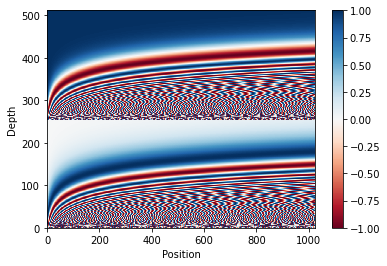

In [55]:
n, d = 1024, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Reshape for plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2,1,0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap="RdBu")
plt.ylabel("Depth")
plt.xlabel("Position")
plt.colorbar()
plt.show()

In [56]:
# Mask the pad token
# The padding token has value 0
# Mask will have value 1 if it is padding
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add newaxis to add padding to attention
    return seq[:, np.newaxis, np.newaxis, :] # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [ ]:
# look ahead mask to mask the future token - indicate which entries should be used

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

In [ ]:
# Scaled dot product attention
# Attention(Q, K, V) = softmax(Q*K.T / sqrt(d))*V (Scale by sqrt(d) to normalize)
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
      output, attention_weights
    """
    print("Q-K-V", q.shape, k.shape, v.shape)
    matmul_qk = tf.matmul(q, k, transpose_b=True) # (..., seq_len_q, seq_len_k) 

    # Scale
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention = matmul_qk / tf.math.sqrt(dk)

    # Mask
    if mask is not None:
        scaled_attention += (mask * -1e9)
    
    # Softmax
    # As the softmax normalization is done on K, its values decide the amount of importance given to Q.
    # The output represents the multiplication of the attention weights and the V (value) vector. 
    # This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.
    attention_weights = tf.nn.softmax(scaled_attention, axis=-1) # (..., seq_q, seq_k)

    output = tf.matmul(attention_weights, v)

    return output, attention_weights



In [ ]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
        q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)


np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

In [ ]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

In [ ]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

In [ ]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

In [ ]:
# Multi head attention
#   Linear layers
#   Scaled dot product attention
#   Concatenation of head
#   Final linear layer
# Each multi-head attention block gets three inputs; Q (query), K (key), V (value).
# These are put through linear (Dense) layers and split up into multiple heads.

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)


    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        # (batch_size, seq_len, d_model)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # (batch_size, num_heads, seq_len_q, depth)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention, shape=(batch_size, -1, self.d_model))

        # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)

        return output, attention_weights





In [ ]:
# At each location in the sequence, y, the MultiHeadAttention runs all 8 attention heads across all other locations in the sequence,
# returning a new vector of the same length at each location.

temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

In [ ]:
# Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation="relu"), # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model), # (batch_size, seq_len, d_model)
    ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

In [ ]:
# Transformer
# The input sentence is passed through N encoder layers that generates an output for each word/token in the sequence.
# The decoder attends on the encoder's output and its own input (self-attention) to predict the next word.

# Encoder layer consists
#   Multi head attention
#   Point wise feed forward

# Each of these sublayers has a residual connection around it followed by a layer normalization. 
# Residual connections help in avoiding the vanishing gradient problem in deep networks.

# The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.
# There are N encoder layers in the transformer.

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.ffn = point_wise_feed_forward_network(d_model=d_model, dff=dff)

        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate=rate)
        self.dropout2 = tf.keras.layers.Dropout(rate=rate)

    def call(self, x, training, mask):
        # (batch_size, input_seq_len, d_model)
        attn_output, _ = self.mha(x, x, x, mask)

        attn_output= self.dropout1(attn_output, training=training)

        # (batch_size, input_seq_len, d_model)
        out1 = self.layer_norm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        out2 = self.layer_norm2(out1 + ffn_output)
        return out2




In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

In [ ]:
# Each decoder layer consists of sublayers:
#   Masked multi-head attention (with look ahead mask and padding mask)
#   Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.
#   Point wise feed forward networks
# Each of these sublayers has a residual connection around it followed by a layer normalization.


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate=rate)
        self.dropout2 = tf.keras.layers.Dropout(rate=rate)
        self.dropout3 = tf.keras.layers.Dropout(rate=rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # (batch_size, target_seq_len, d_model)
        attn1, attn_weights1 = self.mha1(x, x, x, look_ahead_mask)

        attn1 = self.dropout1(attn1)
        out1 = self.layer_norm1(x + attn1)

        attn2, attn_weights2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.layer_norm2(out1 + attn2)

        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.layer_norm3(out2 + ffn_out)

        return out3, attn_weights1, attn_weights2


        

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

In [ ]:
# The Encoder consists of:

#   Input Embedding
#   Positional Encoding
#   N encoder layers
# The input is put through an embedding which is summed with the positional encoding. 
# The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.


class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff=dff, rate=rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate=rate)
    
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]
        # (batch_size, input_seq_len, d_model)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for encoder_layer in self.enc_layers:
            x = encoder_layer(x, training, mask)
        return x

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

In [ ]:
# The Decoder consists of:
#   Output Embedding
#   Positional Encoding
#   N decoder layers
# The target is put through an embedding which is summed with the positional encoding.
# The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.


class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.decode_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate=rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

      seq_len = tf.shape(x)[1]
      attention_weights = {}

      # (batch_size, target_seq_len, d_model)   
      x = self.embedding(x)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :seq_len, :]

      x = self.dropout(x)

      for i, decoder_layer in enumerate(self.decode_layers):
          x, attn_weight1, attn_weight2 = decoder_layer(x, enc_output=enc_output,
                                                        training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

          attention_weights["decoder_layer%d_block1" % (i + 1)] = attn_weight1
          attention_weights["decoder_layer%d_block2" % (i + 1)] = attn_weight2

      
      # x.shape == (batch_size, target_seq_len, d_model)
      return x, attention_weights
          

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

In [ ]:
# Transformer

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads,  dff,
                 input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.tokenizer = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate=rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate=rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, encode_padding_mask, look_ahead_mask, decode_padding_mask):

        # (batch_size, inp_seq_len, d_model)
        enc_output = self.tokenizer(inp, training, encode_padding_mask)

        # decode_output.shape = (batch_size, tar_seq_len, d_model)
        decode_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, decode_padding_mask)

        # (batch_size, tar_seq_len, target_vocab_size)
        final_output = self.final_layer(decode_output)
        return final_output, attention_weights



In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               encode_padding_mask=None, 
                               look_ahead_mask=None,
                               decode_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
# lr_schedule = d_model^(-1/2) * min(step_num^-1/2, step_num * warn_steps^-3/2)

class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warn_steps=4000):
        super(LRSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warn_steps = warn_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warn_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        

In [ ]:
learning_rate = LRSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
temp_learning_rate_schedule = LRSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
sparse_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(target, predict):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = sparse_loss(target, predict)

    mask = tf.cast(mask, loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)


def accuracy_function(target, predict):
    accuracy = tf.equal(target, tf.argmax(predict, axis=2))

    mask = tf.math.logical_not(tf.math.equal(target, 0))
    accuracy = tf.math.logical_and(accuracy, mask)

    accuracy = tf.cast(accuracy, tf.float32)
    mask = tf.cast(mask, tf.float32)
    return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)


In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size(),
    target_vocab_size=tokenizers.en.get_vocab_size(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate
)


In [ ]:
def create_masks(inp, tar):
    # Encoder pad mask
    encode_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    decode_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    decode_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(look_ahead_mask, decode_target_padding_mask)

    return encode_padding_mask, combined_mask, decode_padding_mask



In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 20

# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

# @tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    # sentence = "SOS A lion in the jungle is sleeping EOS"
    # tar_inp = "SOS A lion in the jungle is sleeping"
    # tar_real = "A lion in the jungle is sleeping EOS"


    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    encode_padding_mask, combined_mask, decode_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as g:
        predictions, _ = transformer(
            inp,
            tar_inp,
            True,
            encode_padding_mask,
            combined_mask,
            decode_padding_mask
        )

        loss = loss_function(tar_real, predictions)
    
    gradients = g.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()
    # portuguese -> english

    for (batch, (inp, tar)) in enumerate(train_batches):
        train_step(inp, tar)

        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

In [ ]:
# Evaluate
# Encode the input sentence using the Portuguese tokenizer (tokenizers.pt). This is the encoder input.
# The decoder input is initialized to the [START] token.
# Calculate the padding masks and the look ahead masks.
# The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).
# The model makes predictions of the next word for each word in the output. Most of these are redundant. Use the predictrions from the last word.
# Concatentate the predicted word to the decoder input and pass it to the decoder.
# In this approach, the decoder predicts the next word based on the previous words it predicted.


def evaluate(sentence, max_length=40):
    # inp sentence is portuguese, adding start and end token
    sentence = tf.convert_to_tensor([sentence])
    sentence = tokenizers.pt.tokenize(setence).to_tensor()

    encoder_input = sentence

    # Start, end token
    start, end = tokenizers.en.tokenize('')[0]
    output = tf.convert_to_tensor([start])
    output = tf.expand_dims(output, 0)

    for i in range(max_length):
        encode_padding_mask, combined_padding_mask, decode_padding_mask = create_masks(
            encoder_input, output
        )

        # (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     encode_padding_mask,
                                                     combined_padding_mask,
                                                     decode_padding_mask)
        
        # last word (batch_size, 1, vocab_size)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.argmax(predictions, axis=-1)

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

        # return if found end token
        if predicted_id == end:
            break
        
        # shape(1, tokens)
        text = tokenizers.en.detokenize(output)[0] # shape ()

        tokens = tokenizers.en.lookup(output)[0]

        return text, tokens, attention_weights



In [ ]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
def plot_attention_ahead(in_tokens, out_tokens, attention):
    # The plot is of the attention when a token was generated.
    # The model didn't generate `<START>` in the output. Skip it. 
    out_tokens = out_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(out_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xtickslabels(labels, rotation=90)

    labels = [label.decode('utf-8') for label in out_tokens.numpy()]
    ax.set_ytickslabel(labels)